In [20]:
# Requirements

!pip install transformers
!pip install torch
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-04-13 17:41:50--  https://github.com/LC1332/Luotuo-Text-Embedding/blob/main/lib/tsne.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-04-13 17:41:50 ERROR 404: Not Found.



In [2]:
import torch
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenizer
from argparse import Namespace
# Import our models. The package will take care of downloading the models automatically
tokenizer = AutoTokenizer.from_pretrained("liusiyi641/bert_distilled_openai_mse_cse_cnews")
model_args = Namespace(do_mlm=None, pooler_type="cls", temp=0.05, mlp_only_train=False, init_embeddings_model=None)
model = AutoModel.from_pretrained("liusiyi641/bert_distilled_openai_mse_cse_cnews", trust_remote_code=True, model_args=model_args)


Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import csv
def get_evalCSV():
    text_left = []
    text_right = []
    with open("/content/sentspair.csv", "r") as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            text_left.append(row[0])
            text_right.append(row[1])
    return text_left, text_right

text_left, text_right = get_evalCSV()
inputs = tokenizer(text_left, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    embeddings_left = model(**inputs, output_hidden_states=True, return_dict=True, sent_emb=True).pooler_output
inputs = tokenizer(text_right, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    embeddings_right = model(**inputs, output_hidden_states=True, return_dict=True, sent_emb=True).pooler_output
    
cos_sim_matrix = torch.matmul(embeddings_left, embeddings_right.t())
cos_sim_matrix /= torch.matmul(torch.norm(embeddings_left, dim=1, keepdim=True), torch.norm(embeddings_right, dim=1, keepdim=True).t())
tensor_cpu = cos_sim_matrix.cpu()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
!pip install openai
!pip install openTSNE
!pip install datasets

In [32]:
from tsne import TSNE_Plot

merged_list = text_left + text_right
merged_embed = torch.cat((embeddings_left, embeddings_right), dim=0)
# print(len(merged_list))
# print(len(embeddings_left))
# print(len(embeddings_right))
# print(len(merged_embed))
tsne_plot = TSNE_Plot(merged_list, merged_embed, n_clusters = 4)
tsne_plot.tsne_plot(n_sentence=40)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



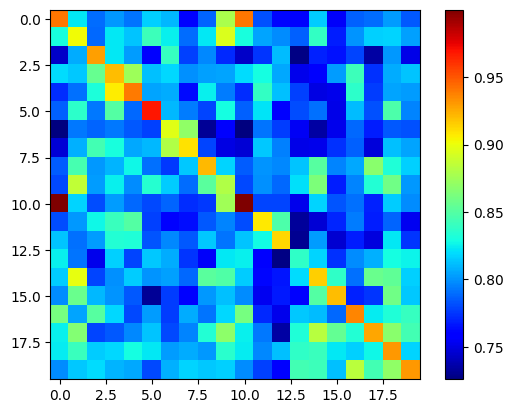

In [19]:
plt.imshow(tensor_cpu, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()